# 基本的信号处理

1. FFT
    1. 生成一个3个正不同频率的正弦波叠加的信号，赋值和频率都不一样
    2. 增加一点点random noise，负值时最小信号幅值的0.1左右
    2. 做个fft，画出频谱图，
    3. 对fft率胳膊，留下其中一个频率，然后还原时域信号
    4. 生成两个正弦波，fft，球相位差
2. interplation 
    1. 搞个单周期正弦信号。就10个点，分别插值到20 50 个点
    2. 用集中不同的插值方法
    3. 画图，画出marker，
3. resampling
    1. 搞个单周期正弦信号。就50个点，用np的slice降到10个
    1. 用血别的将采样方法，将到10个，和30（非整数被）个
    3. 画图，画出marker，
4. fitting
    1. 搞个单周期正弦信号，10个点
    2. 线性、多项式、样条，来一套


# 基本的信号处理

处理信号是工程应用中常见的一种操作，例如处理音频信号，处理电压电流随时间变化的信号等等。
最常用的基本上就是FFT，可以把信号从时域转换到频域处理，也能够反过来。

还有的就是插值，和重采样，有的信号采样率很低，或着你有两个信号，一个信号采样率比较高每个一秒钟记录一次，另一个信号每分钟才记录一次，
如果你要把他们同时送到一个算法里面处理，很多时候需要把他们变成一个采样率的信号。

如果把少的变多，在两个点钟天上缺失的信号点，基本上就要使用插值。如果要巴多的变少，一般会用重采样。

还有一种情况就是需要使用连续的函数来表示离散的点。这个时候就要用到拟合了。关于你和我们这里只讲最简单的。
因为后面还有更多拟合的内容。

## FFT
傅里叶变换是一种基本的信号处理与分析方法，其将时域信号映射至频域，进而研究信号的频谱结构与变化规律。
傅里叶变换的高时间复杂度导致其计算缓慢，FFT是一种小计算量的离散傅里叶变换的实现。
这里不会详细说明FFT的具体底层实现，感兴趣的同学可以去《信号与系统》中阅读对应章节。

这里主要讲解怎么调用scypi来实先fft，以及fft结果的含义，怎利用fft实现一些信号处理。

作为样例，我们生成3种频率、幅值各不相同的正弦波信号并叠加。在此基础上，生成随机噪声。
正弦频率分别为300, 500, 700Hz，幅值分别为10, 20, 30。
根据奈奎斯特采样定理，采样频率需大于信号频率的2倍，原始信号可以从采样样本中重建。采样频率选为2000Hz。

Text(0.5, 1.0, 'Raw Data')

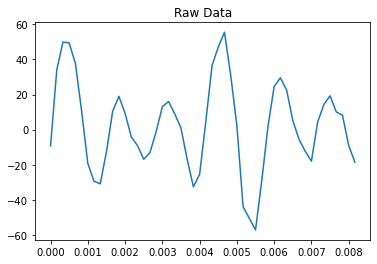

In [6]:
# 产生信号
import numpy as np  # 用以生成信号，python中常用数据处理库，官方文档https://numpy.org/
from scipy.fft import fft, ifft  # scipy中FFT接口，官方文档https://docs.scipy.org/doc/scipy/reference/tutorial/fft.html
from matplotlib import pyplot as plt  # 画图，官方文档https://matplotlib.org/
fs = 6000.  # 采样频率
time = 0.5  # 信号0.5
t = np.linspace(0, time, int(time*fs))  # 生成[0, 1]s的时间轴，采样率fs
N = len(t)  # 采样点数

# 产生信号，最后加上一点噪声
y = 10 * np.sin(2*np.pi*300*t) + 20 * np.sin(2*np.pi*500*t) + \
    30 * np.sin(2*np.pi*700*t) + np.random.normal(0, 5, N)
plt.plot(t[0:50], y[0:50])
plt.title("Raw Data")

In [12]:
fft_y = fft(y)  # 进行FFT变换
print("Length of fft_y is {}".format(len(fft_y)))  # 查看FFT变换后的信号长度
print(fft_y[:5])  # 查看FFT变换后的元素类型

fft_y

Length of fft_y is 3000
[ -74.28578988  -0.j         -104.82007693+166.62613581j
 -230.32762475+262.85364133j -176.99536036+465.35289895j
   55.98544657-105.98508348j]


array([ -74.28578988  -0.j        , -104.82007693+166.62613581j,
       -230.32762475+262.85364133j, ..., -176.99536036-465.35289895j,
       -230.32762475-262.85364133j, -104.82007693-166.62613581j])

可以看到FFT的结果是负数。
可以看出FFT后的信号长度与原始信号是相同的，且变换后是复数。我们容易得到振幅谱和相位谱。
振幅谱就是负数的模，相位谱就是复数的角度。要注意的的，fft的分辨率是fs/N,最高频率是fs/2，所以变换出来的fs个点，
有一半是没有用的，他们是对称的，所以可以扔掉一半。

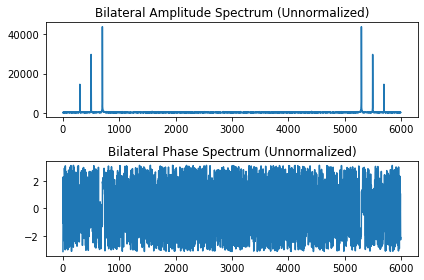

In [13]:
abs_y = np.abs(fft_y)  # 振幅谱
ang_y = np.angle(fft_y)  # 相位谱
f = np.linspace(start=0, stop=N-1, num=N) / N * fs  # 获取真实频率轴，即将频率归一化后乘采样率
plt.subplot(211)
plt.title("Bilateral Amplitude Spectrum (Unnormalized)")
plt.plot(f, abs_y)
plt.subplot(212)
plt.title("Bilateral Phase Spectrum (Unnormalized)")
plt.plot(f, ang_y)

plt.tight_layout()

不难看出振幅谱是对称的，且幅值很大。要得到常规振幅谱需要取单边归一化，直流分量除以点数N，含频率分量除以N/2。
真实频率轴的获取：信号采样频率为 fs，fs/N,最高频率是fs/2，扔掉后一半的点以后，其中任意一点k代表的频率为
k∗fs/N（k=>0~fs/2）。

下面可以看出FFT比较准确的得到了频率信息。

Text(0.5, 1.0, 'Unilateral Amplitude Spectrum (Normalized)')

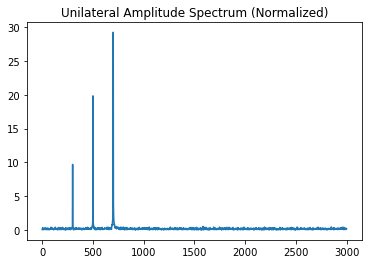

In [14]:
normed_abs_y = abs_y / (N / 2)
half_f = f[:int(N/2)]
normed_abs_y = normed_abs_y[:int(N/2)]
plt.plot(half_f, normed_abs_y)
plt.title("Unilateral Amplitude Spectrum (Normalized)")


假设我们只需要留下400-600Hz这一频段的信息，对FFT滤波后原信号还原：
要注意ifft的使用：
理论上ifft(fft(a)) == a
因此在滤波与还原的时候要使用fft得到的信号进行处理。

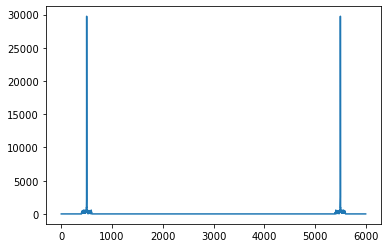

In [15]:
# 简单粗暴直把我们不要的频率接置零
# 关于400Hz，600Hz对称的频率分别是1400和1600

low = int(400*N/fs)
hi = int(600*N/fs)
fft_y2 = fft_y
fft_y2[:low] = 0
fft_y2[-low:] = 0
fft_y2[hi:-hi] = 0
plt.plot(f, np.abs(fft_y))

In [16]:

# 然后调用ifft反变换一下
i_y = ifft(fft_y)
print("Length of inversed y is {}".format(len(i_y)))
print(i_y[:5])


Length of inversed y is 3000
[ 4.40622964-0.0980997j  14.37445381-0.09989859j 20.64544688-0.07700724j
 21.59978009-0.04177924j 16.98921521-0.00832749j]


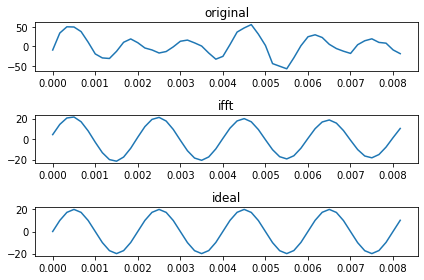

In [17]:
plt.subplot(311)
plt.title("original")
# ifft变换以后也是复数，我们只留下实数部分可以了
plt.plot(t[0:50], y[0:50])

plt.subplot(312)
plt.title("ifft")
# ifft变换以后也是复数，我们只留下实数部分可以了
plt.plot(t[0:50], np.real(i_y)[0:50])

plt.subplot(313)
plt.title("ideal")
plt.plot(t[0:50], 20 * np.sin(2*np.pi*500*t)[0:50])

plt.tight_layout()

```
最后我们尝试利用FFT求同频信号相位差，
目标是通过对应频率点的fft值计算二者相位并做差，因此首先需要找到500Hz对应的，这个前面已经做过了。
首先生成两个同频信号(500Hz)，以及对应的时间轴与频率轴：
```

In [22]:
# 这都是前面的套路你肯定能看懂
fs = 2000
t = np.linspace(0, 1, fs)
N = len(t)
f = np.linspace(start=0, stop=N-1, num=N) / N * fs
y_1 = np.sin(500*2*np.pi*t+np.pi/3)
y_2 = np.sin(500*2*np.pi*t+np.pi/6)


In [23]:
idx = (np.abs(f-500)).argmin()  # 找到距离信号频率最近的频率并返回其索引
print(idx)
print(f[idx])


500
500.0


In [24]:
phase_delta = np.angle(fft(y_1)[idx]) - np.angle(fft(y_2)[idx])
print("计算相位差为：{}".format(phase_delta))
print("真实相位差为：{}".format(np.pi/3-np.pi/6))

计算相位差为：0.5235986419126567
真实相位差为：0.5235987755982988
